# 0. Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob, os
import numpy as np
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Constants (Must match previous notebook)
IMG_SIZE = 64
LATENT_DIM = 32
DATA_PATHS = [
    "/kaggle/input/chess-squares/black/*.png",
    "/kaggle/input/chess-squares/white/*.png",
]
ENCODER_PATH = "/kaggle/input/simclr-encoder/simclr_encoder_black.pth" 

piece_map = {
    'wp': 0, 'wn': 1, 'wb': 2, 'wr': 3, 'wq': 4, 'wk': 5,
    'bp': 6, 'bn': 7, 'bb': 8, 'br': 9, 'bq': 10, 'bk': 11,
    'empty': 12
}

# 1. Dataset (Supervised)
We can reuse the logic from `AutoencoderDataset` because we need `(image, label)` pairs, not the augmented pairs used in SimCLR.

In [2]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class ChessDataset(Dataset):
    def __init__(self, data_glob_paths, transform=None):
        # Allow single string or list of strings
        if isinstance(data_glob_paths, str):
            data_glob_paths = [data_glob_paths]

        self.images = []
        self.labels = []
        self.transform = transform

        image_paths = []
        for path in data_glob_paths:
            image_paths.extend(glob.glob(path))

        for img_path in image_paths:
            piece_code = os.path.basename(img_path).split('_', 1)[0]
            if piece_code not in piece_map:
                continue

            # Open image once to convert to grayscale
            img = Image.open(img_path).convert('L')
            self.images.append(img)
            self.labels.append(piece_map[piece_code])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

In [3]:
# Load Data
full_dataset = ChessDataset(DATA_PATHS, transform=None) # Transform handled in split

# Split Train/Val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

# Apply transforms specifically to subsets
class SubsetWrapper(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

train_data = SubsetWrapper(train_subset, train_transform)
val_data = SubsetWrapper(val_subset, val_transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

# 2. Define Classifier Model
We must redefine the Encoder architecture exactly as it was in the SimCLR notebook to load the weights.

In [4]:
class SimCLRClassifier(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM, num_classes=13, freeze_encoder=True):
        super().__init__()
        
        # 1. Define Encoder (Must match SimCLR architecture exactly)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, latent_dim),
        )

        # 2. Classification Head
        # Takes the latent vector (32) and maps to classes (13)
        self.classifier = nn.Linear(latent_dim, num_classes)

        # 3. Load Pre-trained Weights
        try:
            state_dict = torch.load(ENCODER_PATH, map_location=device)
            self.encoder.load_state_dict(state_dict)
            print("Pre-trained weights loaded successfully!")
        except FileNotFoundError:
            print("WARNING: Weight file not found. Initializing with random weights.")

        # 4. Freeze Encoder (Linear Evaluation)
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
            print("Encoder weights frozen.")

    def forward(self, x):
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

# 3. Training Loop

Pre-trained weights loaded successfully!
Encoder weights frozen.
Starting Linear Evaluation...
Epoch 10/200 | Train Loss: 0.4475 | Val Loss: 0.4272 | Train Acc: 86.52% | Val Acc: 87.60%
Epoch 20/200 | Train Loss: 0.3792 | Val Loss: 0.3548 | Train Acc: 88.51% | Val Acc: 88.92%
Epoch 30/200 | Train Loss: 0.3470 | Val Loss: 0.3344 | Train Acc: 89.07% | Val Acc: 89.66%
Epoch 40/200 | Train Loss: 0.3370 | Val Loss: 0.3224 | Train Acc: 89.57% | Val Acc: 89.51%
Epoch 50/200 | Train Loss: 0.3246 | Val Loss: 0.3129 | Train Acc: 89.60% | Val Acc: 90.31%
Epoch 60/200 | Train Loss: 0.3201 | Val Loss: 0.3086 | Train Acc: 89.81% | Val Acc: 90.34%
Epoch 70/200 | Train Loss: 0.3156 | Val Loss: 0.2981 | Train Acc: 89.81% | Val Acc: 90.18%
Epoch 80/200 | Train Loss: 0.3062 | Val Loss: 0.2930 | Train Acc: 89.95% | Val Acc: 90.55%
Epoch 90/200 | Train Loss: 0.3103 | Val Loss: 0.2929 | Train Acc: 89.94% | Val Acc: 90.34%
Epoch 100/200 | Train Loss: 0.3056 | Val Loss: 0.2933 | Train Acc: 90.10% | Val Acc: 9

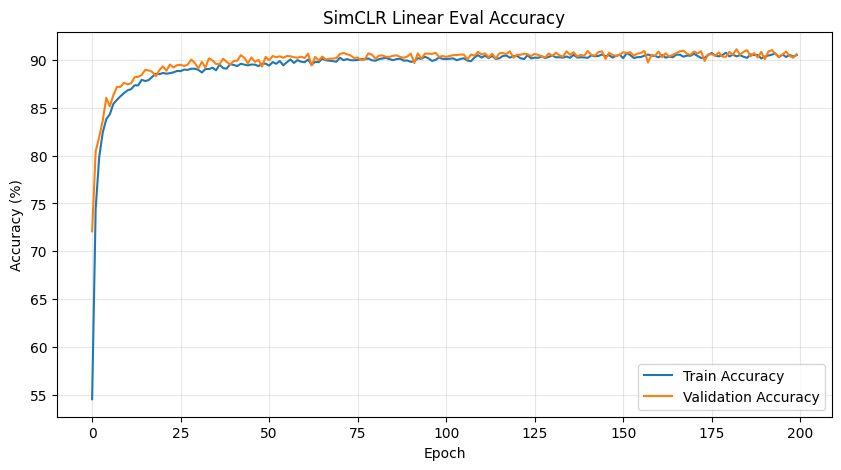

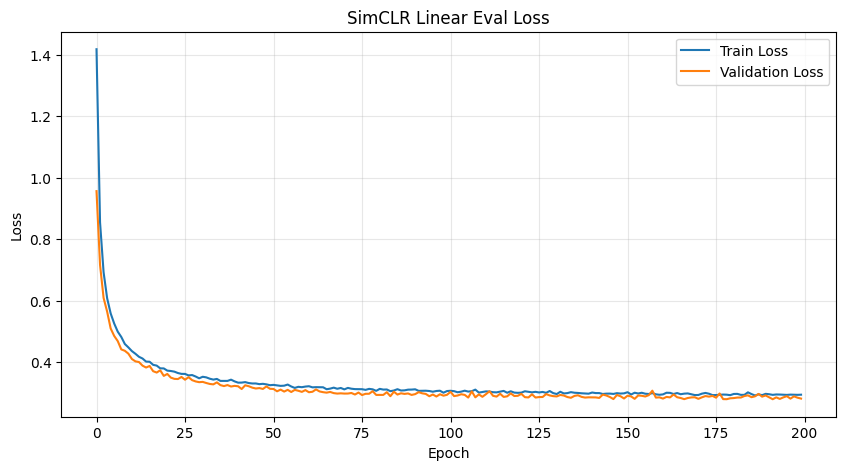

In [5]:
# Initialize Model
model = SimCLRClassifier(freeze_encoder=True).to(device)
# Optimizer (Only optimize the classifier head if frozen)
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss()
EPOCHS = 200
train_accs, val_accs = [], []
train_losses, val_losses = [], []

print("Starting Linear Evaluation...")
for epoch in range(EPOCHS):
    # --- Training ---
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    train_loss = total_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    # --- Validation ---
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            
    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(val_loader)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("SimCLR Linear Eval Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("SimCLR Linear Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

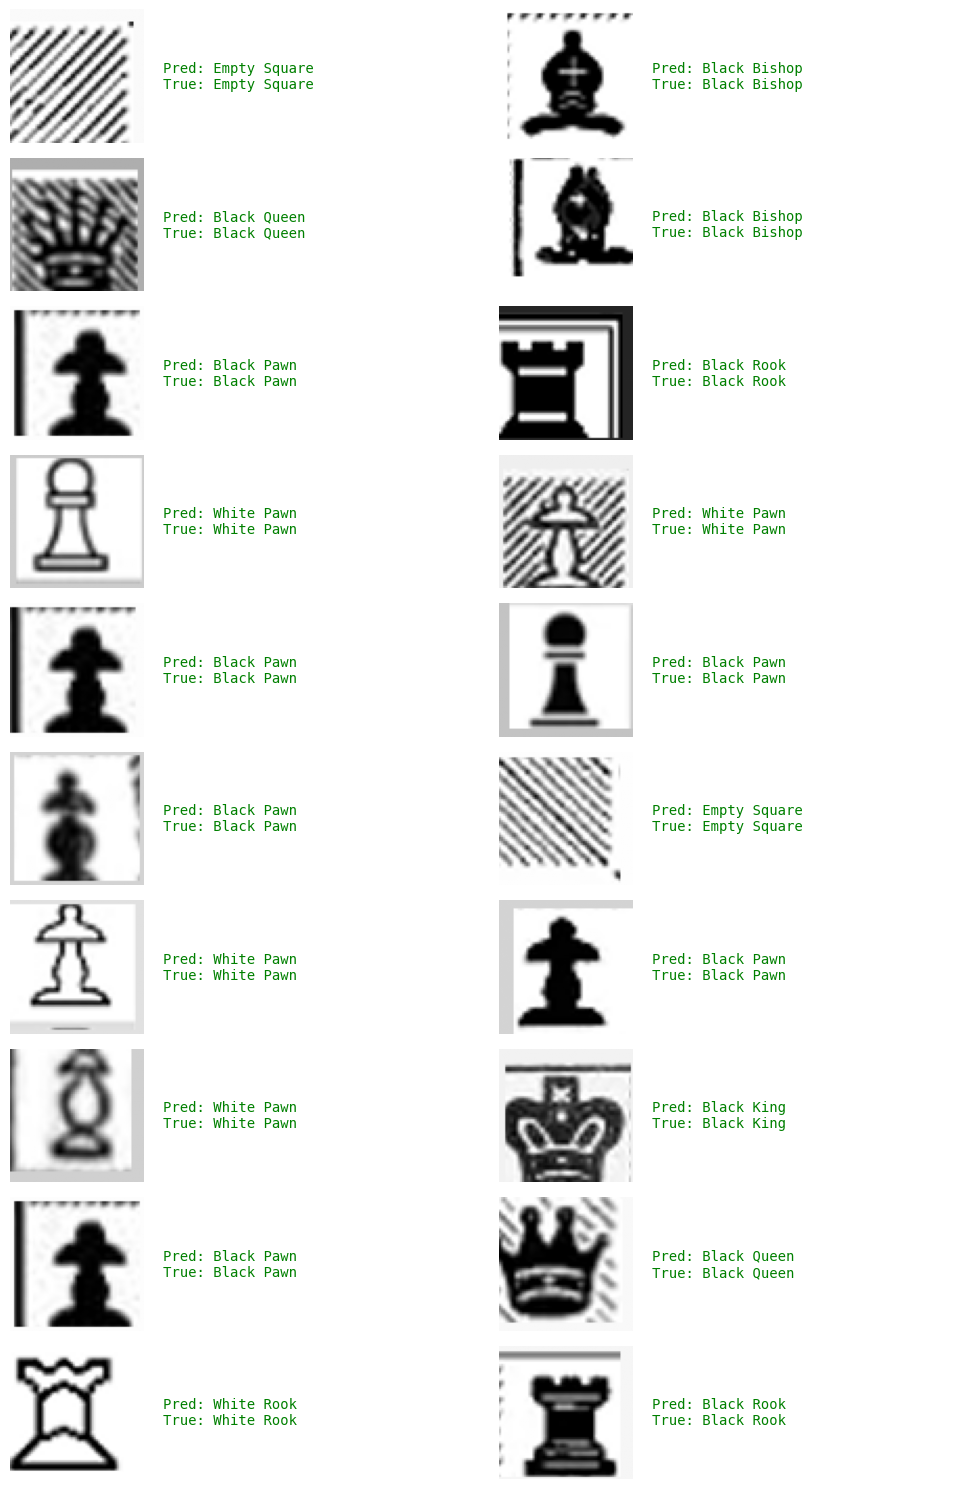

In [6]:
# --- Configuration ---
NUM_SAMPLES = 20
# ---------------------
# 1. Setup Reverse Mapping (Index -> Human Readable Name)
idx_to_text = {
  0: 'White Pawn', 1: 'White Knight', 2: 'White Bishop',
  3: 'White Rook', 4: 'White Queen', 5: 'White King',
  6: 'Black Pawn', 7: 'Black Knight', 8: 'Black Bishop',
  9: 'Black Rook', 10: 'Black Queen', 11: 'Black King',
  12: 'Empty Square'
}

# 2. Select Random Samples
indices = np.random.choice(len(val_data), NUM_SAMPLES, replace=False)

# 3. Visualization
model.eval()
rows = (NUM_SAMPLES + 1) // 2  # Ceiling division for 2 columns
fig, axes = plt.subplots(rows, 4, figsize=(10, rows * 1.5), 
                         gridspec_kw={'width_ratios': [1, 2, 1, 2]})

# Flatten axes for easier indexing
axes = axes.reshape(-1, 4) if NUM_SAMPLES > 2 else axes.reshape(1, 4)

for ax_row in axes:
    ax_row[1].axis('off')
    ax_row[3].axis('off')

with torch.no_grad():
    for i, idx in enumerate(indices):
        row = i // 2
        col_offset = (i % 2) * 2  # 0 for left column, 2 for right column
        
        image_tensor, label_idx = val_data[idx]
        input_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Inference
        logits = model(input_tensor)
        predicted_idx = torch.argmax(logits, dim=1).item()
        
        pred_text = idx_to_text[predicted_idx]
        true_text = idx_to_text[label_idx]
        text_color = 'green' if predicted_idx == label_idx else 'red'
        
        # Image
        img_display = image_tensor.squeeze().cpu().numpy()
        axes[row, col_offset].imshow(img_display, cmap='gray')
        axes[row, col_offset].axis('off')
        
        # Text
        text_str = f"Pred: {pred_text}\nTrue: {true_text}"
        axes[row, col_offset + 1].text(0, 0.5, text_str, fontsize=10, va='center', 
                                       color=text_color, fontfamily='monospace')

# Hide unused subplots if NUM_SAMPLES is odd
if NUM_SAMPLES % 2 == 1:
    axes[-1, 2].axis('off')
    axes[-1, 3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# 1. Set model to eval mode (crucial for batch norm/dropout layers)
model.eval()

# 2. Create a dummy input matching your input shape
# Shape: (Batch_Size, Channels, Height, Width) -> (1, 1, 64, 64)
dummy_input = torch.randn(1, 1, 64, 64).to(device)

# 3. Export
onnx_filename = "chess_classifier.onnx"
torch.onnx.export(
    model,                      # Model being run
    dummy_input,                # Model input (or a tuple for multiple inputs)
    onnx_filename,              # Where to save the model
    export_params=True,         # Store the trained parameter weights inside the model file
    opset_version=12,           # The ONNX version to export the model to
    do_constant_folding=True,   # Whether to execute constant folding for optimization
    input_names=['input'],      # The model's input names
    output_names=['output'],    # The model's output names
    dynamic_axes={              # Variable length axes (so you can infer 1 or multiple images)
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to {onnx_filename}")

/tmp/ipykernel_24/3169350444.py:10: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


Model exported to chess_classifier.onnx
